# Prepare functions

# Setup

In [1]:
import sys
sys.path.insert(1, '/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle')

In [2]:
import os

subset = 'NeuralPCW24'
os.chdir(f'/users/genomics/xoel/codebases/co_new/data/{subset}/')

In [3]:
import scanpy as sc
sc.set_figure_params(
    scanpy=True,
    dpi=80, 
    dpi_save=300, 
    frameon=True,
    vector_friendly=True, 
    fontsize=14, 
    figsize=None, 
    color_map=None,
    facecolor=None, 
    transparent=False, 
    ipython_format='png2x')
sc.settings.verbosity=4
sc.settings.autosave=True
sc.settings.autoshow=True

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
n_cores = min(int(os.getenv('SLURM_CPUS_PER_TASK')) -4 or 18, 96)


# **Part 1 //** Create a gene regulatory network (GRN)

## Find ATAC coaccessible peaks

In [24]:
from cicero_helper import create_cicero_cmd

In [4]:
os.listdir()

['RNA.unprocessed.h5ad',
 'log.test.txt',
 'cicero_umap.pdf',
 'temp_cicero.sh',
 'ATAC.peak_metadata.tsv',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_connections.csv',
 'Rplots.pdf',
 'cicero_peaks.csv',
 'ATAC.cell_metadata.tsv']

In [5]:
r_cmd = create_cicero_cmd( 
    atac_path='ATAC.unprocessed.tsv',
    peaks_bed_path='ATAC.peak_metadata.tsv',
    cell_metadata_path='ATAC.cell_metadata.tsv', 
    plot_by='cell.type', 
    R_quote='',
    str_quote="\'",
    save_dir='./', 
    prefix=None, 
    verbose='TRUE')

with open('temp_cicero.sh', 'wt') as f:
    f.writelines(r_cmd)
print(r_cmd)

source('~/canonades/bioinforgalician/src/python/celloracle/cicero.R',echo=TRUE)

pipe_cicero_conns(atac_path='ATAC.unprocessed.tsv',peaks_bed_path='ATAC.peak_metadata.tsv',cell_metadata_path='ATAC.cell_metadata.tsv',plot_by='cell.type',save_dir='./',prefix=NULL,verbose=TRUE)


In [6]:
%%bash -s "$r_cmd" "$subset"
eval "$(micromamba shell hook --shell=bash)"
micromamba activate ~/venvs/cicero
# LOCAL
# Rscript --vanilla --verbose ./temp_cicero.sh
# sbatch --job-name=$2 --output=log.test.txt --mem=185GB --time=4-00:00:00 --partition=normal,long,bigmem --cpus-per-task=20 --wrap="Rscript --vanilla --verbose ./temp_cicero.sh"

In [7]:
# !while [ 1 ]; do tail log.test.txt; sleep 30; clear; done
!cat log.test.txt | grep -v 'chr1' |  tail -20

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.524499358352712
Median shared cells bin-bin: 0
[2] Running cicero analysis
[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  9575"
[1] "Other models: "

  Too many elements in range Zero or one element in range 
                        1135                         2390 
[1] "Models with errors:  0"
[1] "Done"
[SAVE] Saving connections & peaks
                          Peak1                     Peak2      coaccess
 [ reached 'max' / getOption("max.print") -- omitted 102794307 rows ]


In [8]:
!rm ./temp_cicero.sh

## Run motif analysis and filter

In [9]:
import cicero_to_grn 

Adding to PATH: /soft/system/software/BEDTools/2.30.0-GCC-10.2.0/bin


In [10]:
os.listdir()

['RNA.unprocessed.h5ad',
 'log.test.txt',
 'cicero_umap.pdf',
 'ATAC.peak_metadata.tsv',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_connections.csv',
 'Rplots.pdf',
 'cicero_peaks.csv',
 'ATAC.cell_metadata.tsv']

In [12]:
grn_result = cicero_to_grn.run_motif_analysis(
    peaks_csv='cicero_peaks.csv',
    connections_csv='cicero_connections.csv',
    
    extra_peaks=None,
    ref_genome='hg38',
    provider='UCSC',
    frp=0.02,
    coacc_thres=0.8,
    motifs=None,
    motif_score_thres=8,
    save_dir='./',
    prefix=None,
    verbose=True
)

[1] Loading peaks and connections
[2] Loading genome
hg38 is installed.
[3] Integrating peaks, connections and genome
que bed peaks: 655261
tss peaks in que: 44655
[4] Filtering peaks by coaccessibility (0.8)
Over threshold: 2.33 %
[5] Extracting peaks
[6] Performing motif scan (frp: 0.02)
No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/40235 [00:00<?, ? sequences/s]

[7] Filtering motif score (motif_score_thres)
Over threshold: 49.66 %
Filtering finished: 11149530 -> 4125445
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/40235 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/20014 [00:00<?, ?it/s]

  0%|          | 0/1098 [00:00<?, ?it/s]

[8] Saving results


  0%|          | 0/3 [00:00<?, ?it/s]

# **Part 2 //** Prepare RNA data

In [5]:
import scanpy as sc
import prepare_rna
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [6]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [8]:
adata_file = 'RNA.unprocessed.h5ad'
adata_complete = sc.read_h5ad(adata_file)

In [9]:
dict(
    RGCmaturationExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    RGCmaturation = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    NeuralPCW16 = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    NeuralPCW20 = 'hft_w20_p3_r1_AATGACCTCTACCAGA',
    # NeuralPCW24='hft_w24_p6_r2_GTGGTTATCGGTCTAA'
    # NeuralPCW24 = 'hft_w24_p6_r2_GATTGGTTCCTACCGT',
    NeuralPCW24 = 'hft_w24_p6_r2_CTTCTCTAGTTCTACG',
    
    Gliogenesis = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    GliogenesisExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
)

{'RGCmaturationExtended': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'RGCmaturation': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'NeuralPCW16': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'NeuralPCW20': 'hft_w20_p3_r1_AATGACCTCTACCAGA',
 'NeuralPCW24': 'hft_w24_p6_r2_CTTCTCTAGTTCTACG',
 'Gliogenesis': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'GliogenesisExtended': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC'}

### PIPE [1] PREPROCESSING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Saving raw counts
[2] Computing QC
[3] Filtering genes: total_counts > 1
[4] Normalizing per cell using total_counts
normalizing by total count per cell
    finished (0:00:08): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[5] Computing highly variable genes and filtering to top 3000
(7709, 17060)
extracting highly variable genes
    the 3000 top genes correspond to a normalized dispersion cutoff of 1.4360313415527344
    finished (0:00:00)


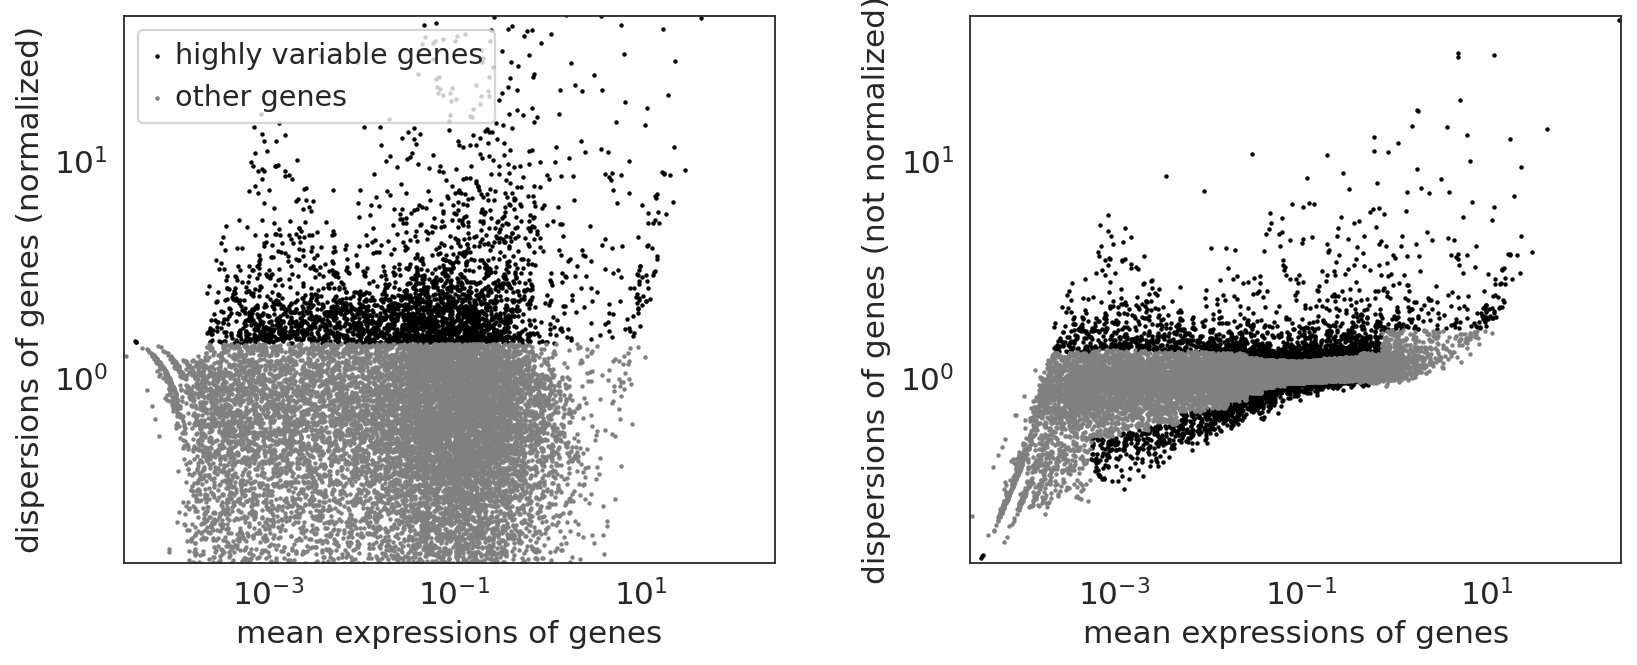

(7709, 3000)
[6] Normalizing per cell again using total_counts
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[7] Log1p transformation
[8] Scaling
### PIPE [2] EMBEDDING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Computing PCA
computing PCA
    with n_comps=50
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


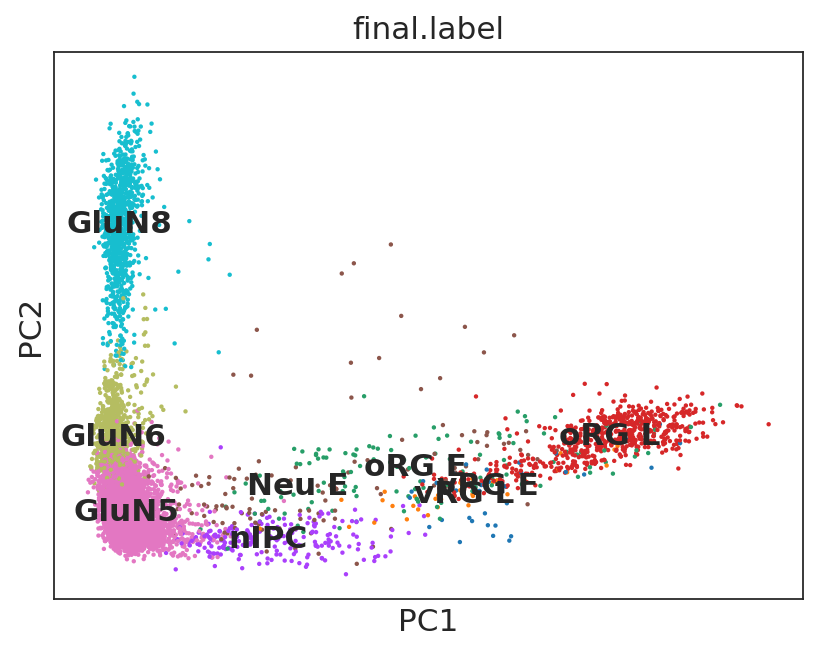

[2] Computing neighbors
computing neighbors
    computing neighbors
    computed neighbors (0:00:01)
    computed connectivities (0:00:17)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
[3] Computing diffusion map
computing Diffusion Maps using n_comps=30(=n_dcs)
        initialized `.distances` `.connectivities` 
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99833053 0.9979214  0.9913995  0.9894775  0.9856106
     0.984828   0.98291326 0.9757316  0.973024   0.9688443  0.9652479
     0.96328545 0.9587401  0.9571153  0.9513449  0.94831663 0.9477259
     0.94401747 0.93945485 0.9339216  0.93369395 0.92654234 0.92600113
     0.92141074 0.91714394 0.9142582  0.9129202  0.9079144  0.9045287 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix

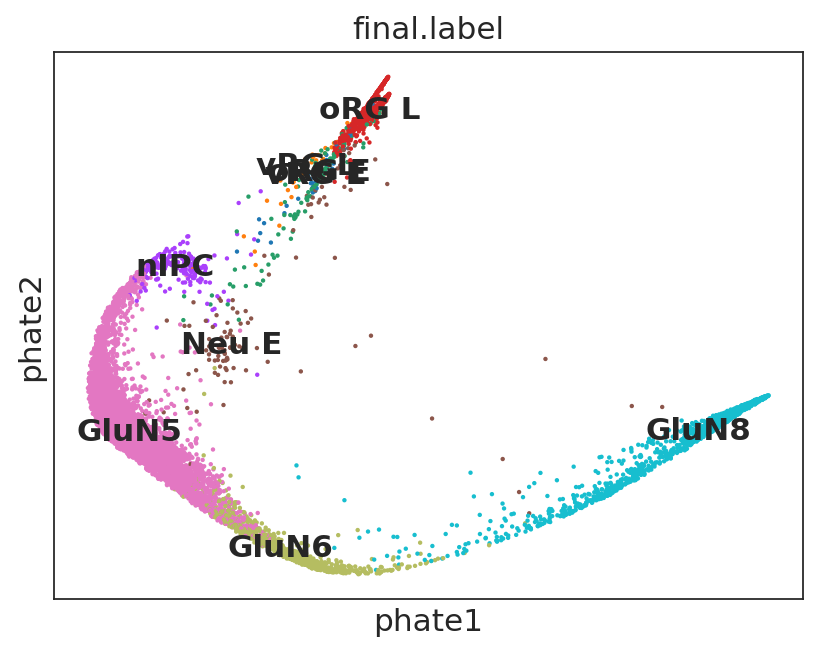

### PIPE [3] COMPUTING PSEUDOTIME


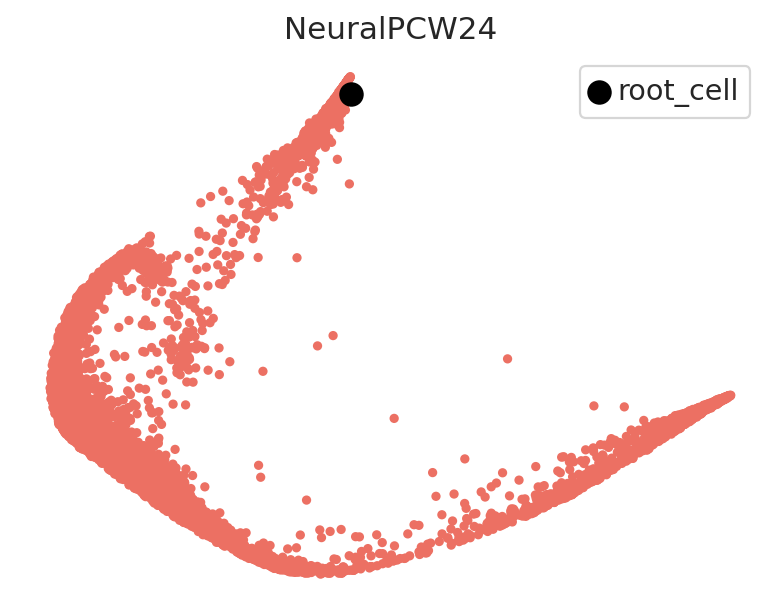

        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


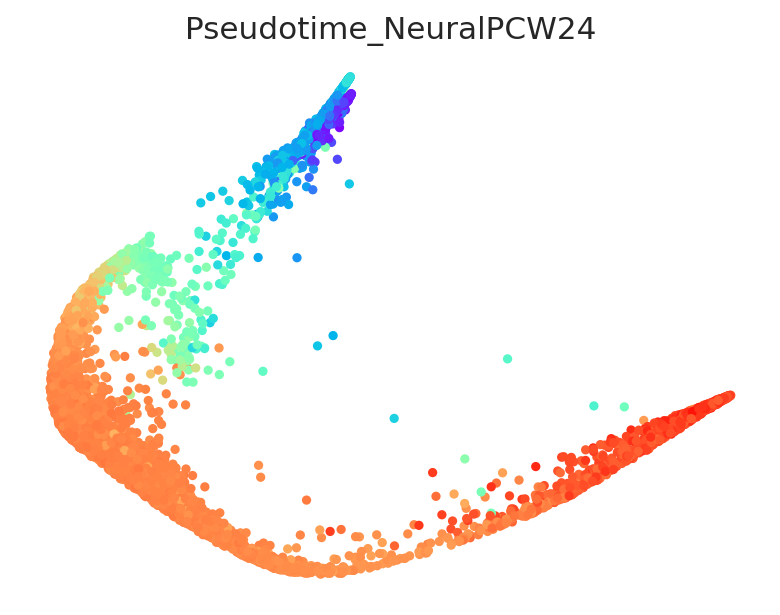

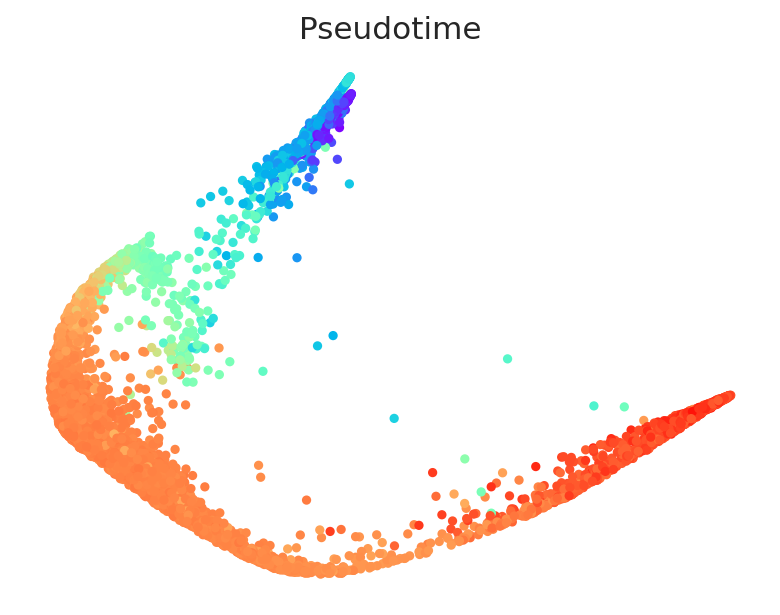

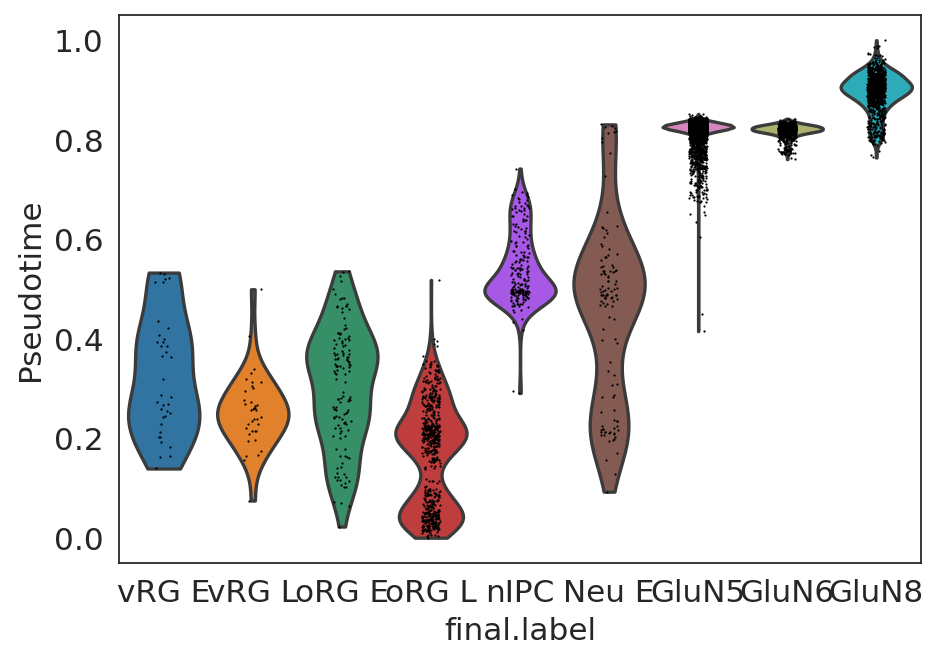

### PIPE [4] SAVING DATA


In [10]:
adata = prepare_rna.prepare_adata(
    
    adata_complete,
    group_by='final.label',
    save_dir='./',
    
    min_total_counts_per_cell=1,
    key_n_counts='total_counts',
    n_top_genes=3000,


    nn_1_n_neighbors=20,
    nn_1_use_rep='X_pca',
    nn_1_n_pcs=10,
    dm_n_comps=30,
    nn_2_n_neighbors=100,

    phate_run_on='X_scvi',
    phate_knn=100, 
    phate_n_pca=30, 
    phate_decay=15, 
    phate_t='auto',
    
    skip_umap=True,
    skip_paga=True,
    skip_phate=False,
    random_state=None,    

    root_cells='hft_w24_p6_r2_CTTCTCTAGTTCTACG',
    lineages=None, 
    lineage_name=subset,
    embedding_key='X_phate',
    # embedding_key='X_draw_graph_fa',
    verbose=True)

# **Part 3 //** Fit GRN to expression

In [11]:
import network_fit

In [12]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [13]:
oracle, links = network_fit.network_fit_pipe(
    adata_fname = 'RNA.processed.h5ad',
    base_GRN_fname = 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
    cluster_column_name = 'final.label',
    max_n_pcs = 50,
    links_alpha=10,
    
    embedding_name='X_phate',

    tempdir=f'/scratch/{subset}/tmp/',
    
    links_pval=0.001,
    links_top_n_coef=2000,
    seed = 4,
    verbose = True,
    save_dir='./',
    test_mode=False)

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Reading data
Loading adata
Loading GRN
[2] Prepairing oracle object


  0%|          | 0/4 [00:00<?, ?it/s]

[1] Instatiating Oracle with raw RNA-Seq data
    Expression range: count     7709.000000
mean      2683.444580
std       2042.002319
min        233.000000
25%       1387.000000
50%       1770.000000
75%       3447.000000
max      14534.000000
dtype: float64
[2] Adding GRN data to Oracle
[3] Computing and selecting PCs and k for neighbors
[4] Computing KNNs:
    n cells: 7709
    k: 192
    oracle.knn_imputation(n_pca_dims=n_comps, k=192, balanced=True, b_sight=1536, b_maxl=768, n_jobs=-1)
Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 7709
    n_genes: 3000
    cluster_name: final.label
    dimensional_reduction_name: X_phate
    n_target_genes_in_TFdict: 20014 genes
    n_regulatory_in_TFdict: 1098 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 173 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2711 genes
    k_for_knn_imputation: 192
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn i

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for GluN5...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for GluN6...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for GluN8...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for Neu E...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for nIPC...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for oRG E...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for oRG L...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for vRG E...


  0%|          | 0/2711 [00:00<?, ?it/s]

Inferring GRN for vRG L...


  0%|          | 0/2711 [00:00<?, ?it/s]

[4] Checking links
All fits are valid.
[5] Postprocessing links
[6] Scoring genes


  0%|          | 0/9 [00:00<?, ?it/s]

/scratch/NeuralPCW24/tmp/24/11/scratch/NeuralPCW24/tmp/24/62/scratch/NeuralPCW24/tmp/24/81/scratch/NeuralPCW24/tmp/24/1

/scratch/NeuralPCW24/tmp/24/23

/scratch/NeuralPCW24/tmp/24/67/scratch/NeuralPCW24/tmp/24/60


/scratch/NeuralPCW24/tmp/24/5
/scratch/NeuralPCW24/tmp/24/56
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:


Attaching package: ‘igraph’
    union


The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following 

[7] Saving results
- Saving raw links per cluster


  0%|          | 0/9 [00:00<?, ?it/s]

- Saving filtered links per cluster


  0%|          | 0/9 [00:00<?, ?it/s]

- Saving processed links
- Saving oracle


In [14]:
%matplotlib Agg
network_fit.pipe_plots(links)

  0%|          | 0/5 [00:00<?, ?it/s]

GluN5
GluN6
GluN8
Neu E
nIPC
oRG E
oRG L
vRG E
vRG L


  0%|          | 0/9 [00:00<?, ?it/s]

degree_centrality_all
eigenvector_centrality


  0%|          | 0/3 [00:00<?, ?it/s]

Genes in filtered network: 902


  0%|          | 0/902 [00:00<?, ?it/s]

ABHD17A
ACAT2
ACSL6
ACTB
ACTG1
ADCY1
ADD3
ADGRG1
ADGRV1
ADRA2A
AGT
AKAP9
ALCAM
ALDOC
ANKRD9
ANP32B
ANP32E
ANXA1
ANXA2
ANXA5
APOE
AQP4
AQR
ARC
ARHGAP11A
ARHGAP20
ARHGAP5
ARHGDIG
ARID5B
ARL4A
ARL4C
ARPP21
ARX
ASCL1
ASPM
ATAD2
ATAD5
ATCAY
ATF3
ATP1A2
ATP1B1
ATP1B2
ATP2B1
AURKA
AURKAIP1
AURKB
B2M
B3GAT1
B3GAT2
BAIAP2
BARD1
BARX2
BASP1
BATF3
BAZ1A
BBX
BCAN
BCL11A
BCL11B
BCL3
BCL6
BHLHE22
BHLHE40
BICD1
BIRC5
BNIP3
BOC
BORCS8
BRCA1
BTBD17
BTBD8
BTG1
BTG2
BTG3
BUB1
BUB1B
C11orf96
C14orf132
C1QL2
C1orf115
C21orf58
CA12
CA2
CA3
CACNA1A
CACNA2D1
CACNG3
CADM1
CADM2
CALD1
CALM1
CALN1
CALY
CAMK1D
CAMK2B
CAMK4
CASC15
CASP1
CASP3
CAV2
CBLN2
CCBE1
CCDC106
CCDC107
CCDC144A
CCDC184
CCN1
CCNA2
CCNB1
CCNB2
CCND2
CCNI
CCNL1
CD24
CD9
CDC123
CDC20
CDC42EP3
CDCA3
CDCA4
CDCA7
CDCA8
CDH11
CDH13
CDK1
CDK5
CDKN2C
CDKN3
CDO1
CEBPD
CELF4
CENPA
CENPE
CENPF
CENPH
CENPK
CENPM
CENPN
CENPU
CEP126
CEP78
CEP85L
CHCHD6
CHD5
CHD7
CHL1
CHPF
CHST1
CKAP2
CKAP2L
CKB
CKS2
CLDN10
CLMP
CLSPN
CLU
CNN3
CNR1
CNTN1
CNTN3
CNTN4
CNTNAP2


  0%|          | 0/902 [00:00<?, ?it/s]

()

# **Part 4 //** Perturbation analysis

In [5]:
import perturbations

In [6]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [7]:
%matplotlib inline

In [8]:
# o = perturbations.co.load_hdf5('Oracle.celloracle.oracle')

# knn = o.adata.obs['final.label'].value_counts().min()-2
# knn

In [15]:
knn=35

In [16]:
groups = {
    'vRG': ['vRG E', 'vRG L'],
    'vtRG': ['vRG E', 'vRG L', 'tRG'],
    'oRG': ['oRG E', 'oRG L'],
    'RG E': ['vRG E', 'vRG E'],
    'RG L': ['vRG E', 'vRG L'],
    'RGC': ['vRG E','vRG L','tRG','oRG E','oRG L'],
    'Neural': ['Neu E', 'nIPC', 'GluN5', 'GluN6', 'GluN8'],
    'GluN': ['GluN5', 'GluN6', 'GluN8']
}

oracle.adata.obs['final.label'].cat.categories

Index(['vRG E', 'vRG L', 'oRG E', 'oRG L', 'nIPC', 'Neu E', 'GluN5', 'GluN6',
       'GluN8'],
      dtype='object')

### KO simulation

In [9]:
%matplotlib Agg
# %matplotlib inline

In [10]:
import celloracle as co

oracle = co.load_hdf5('./Oracle.Perturbation.celloracle.oracle')
gradient = co.load_hdf5('./Gradient.Perturbation.celloracle.gradient')

In [17]:
ps_sums = perturbations.run_systemic_simulation_async(oracle, gradient, groups=groups, 
                                                      genes=['FOXG1'],#['EOMES'],
                                                      
                                                      p_mass_smooth=0.8,
                                                      p_mass_n_grid=40,
                                                      p_mass_n_neighbors=knn,
                                                      p_mass_filter_min=1000,
                                                      
                                                      
                                                      n_cores=n_cores, n_parallel_genes=1, overwrite=True)

Excluding: []
Selected number of neighbors: 37


0it [00:00, ?it/s]

Getting PS for all groups


ValueError: No objects to concatenate

In [18]:
'FOXG1' in oracle.adata.var_names

False